<a href="https://colab.research.google.com/github/emilymacris/ds4002-project3/blob/main/project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/emilymacris/ds4002-project3

Cloning into 'ds4002-project3'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 716.76 KiB | 5.88 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
!pip install earthengine-api
!pip install geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.9 MB/s eta 0:00:00


In [3]:
import ee
import geemap

In [4]:
ee.Authenticate()
ee.Initialize(project='ee-bdf7bz')


In [5]:
aoi = ee.Geometry.Rectangle([-147.5, 60.7, -146.5, 61.3])  # Columbia Glacier area

# Use the new Collection 2 dataset
image = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(aoi) \
    .filterDate('2021-06-01', '2021-08-31') \
    .median() \
    .clip(aoi)

Map = geemap.Map(center=[60.9, -147.0], zoom=9)
Map.addLayer(image, {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 30000}, 'True Color')
Map


Map(center=[60.9, -147.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [6]:
# Compute NDSI (snow/ice index)
ndsi = image.normalizedDifference(['SR_B3', 'SR_B6']).rename('NDSI')

# Compute NDVI (vegetation index)
ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

# Add them to your image
image = image.addBands([ndsi, ndvi])
Map.addLayer(ndsi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'NDSI')
Map

Map(center=[60.9, -147.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [7]:
stats = image.reduceRegion(
    reducer=ee.Reducer.mean().combine(
        ee.Reducer.minMax(), sharedInputs=True
    ),
    geometry=aoi,
    scale=30,
    maxPixels=1e9  # set this high enough
)

print(stats.getInfo())

{'NDSI_max': 0.6992718423254874, 'NDSI_mean': 0.27645546402542265, 'NDSI_min': -0.24924760601915186, 'NDVI_max': 0.49193415019168607, 'NDVI_mean': 0.0023312195551571453, 'NDVI_min': -0.24774450769641793, 'QA_PIXEL_max': 55052, 'QA_PIXEL_mean': 29214.648746123956, 'QA_PIXEL_min': 21824, 'QA_RADSAT_max': 0, 'QA_RADSAT_mean': 0, 'QA_RADSAT_min': 0, 'SR_B1_max': 51294, 'SR_B1_mean': 27955.507232166034, 'SR_B1_min': 7268.5, 'SR_B2_max': 51687, 'SR_B2_mean': 27746.56865703108, 'SR_B2_min': 7390.5, 'SR_B3_max': 50195, 'SR_B3_mean': 26570.27409479051, 'SR_B3_min': 7616, 'SR_B4_max': 49245, 'SR_B4_mean': 26063.758652711276, 'SR_B4_min': 7233.5, 'SR_B5_max': 43481, 'SR_B5_mean': 25575.654640620916, 'SR_B5_min': 7181.5, 'SR_B6_max': 25396.5, 'SR_B6_mean': 13499.973213853438, 'SR_B6_min': 7273, 'SR_B7_max': 20268.5, 'SR_B7_mean': 13170.400187243331, 'SR_B7_min': 7438.5, 'SR_QA_AEROSOL_max': 224, 'SR_QA_AEROSOL_mean': 204.24971759211613, 'SR_QA_AEROSOL_min': 1, 'ST_ATRAN_max': 9404, 'ST_ATRAN_mean'

In [8]:
training_points = ee.FeatureCollection('users/bdf7bz/glacier_training')


In [9]:
training_data = image.sampleRegions(
    collection=training_points,
    properties=['class'],  # label column
    scale=30
)

In [10]:
import pandas as pd
import json

# Convert EE FeatureCollection to GeoJSON dictionary
geojson = geemap.ee_to_geojson(training_data)

# Convert to pandas DataFrame
df = pd.json_normalize(geojson['features'])

# Preview
df.head()

,type,geometry,id,properties.NDSI,properties.NDVI,properties.QA_PIXEL,properties.QA_RADSAT,properties.SR_B1,properties.SR_B2,properties.SR_B3,...,properties.ST_ATRAN,properties.ST_B10,properties.ST_CDIST,properties.ST_DRAD,properties.ST_EMIS,properties.ST_EMSD,properties.ST_QA,properties.ST_TRAD,properties.ST_URAD,properties.class
0,Feature,None,00000000000000000000_0,0.296557,-0.008578,22280,0,36202.5,35741.0,33392.5,...,7932.0,35916.5,0.0,634.5,9706.0,65,679.0,6056.5,1276.5,1
1,Feature,None,00000000000000000001_0,0.287143,-0.004286,22280,0,39003.5,38574.0,36059.0,...,8171.0,34615.5,0.0,563.0,9696.0,0,686.0,5743.0,1112.0,1
2,Feature,None,00000000000000000002_0,0.356426,-0.014171,22280,0,37301.0,36856.5,34704.5,...,7809.0,34994.5,0.0,690.5,9658.0,57,687.5,5744.5,1387.5,1
3,Feature,None,00000000000000000003_0,0.329418,-0.014913,23212,0,35747.5,35647.0,34126.5,...,8200.5,33530.5,0.0,555.0,9534.0,60,687.0,5337.0,1094.0,1
4,Feature,None,00000000000000000004_0,0.329722,-0.004062,22280,0,36560.5,36077.5,34241.0,...,8375.5,33855.0,0.0,490.0,9712.0,140,676.5,5325.5,952.0,1


In [11]:
# Clean column names (remove 'properties.' prefix)
df.columns = df.columns.str.replace('properties.', '', regex=False)

# Drop unnecessary columns
drop_cols = ['type', 'geometry', 'id']
df_clean = df.drop(columns=drop_cols)

# Preview cleaned data
df_clean.head()

,NDSI,NDVI,QA_PIXEL,QA_RADSAT,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,...,ST_ATRAN,ST_B10,ST_CDIST,ST_DRAD,ST_EMIS,ST_EMSD,ST_QA,ST_TRAD,ST_URAD,class
0,0.296557,-0.008578,22280,0,36202.5,35741.0,33392.5,32890.5,32331.0,18117.0,...,7932.0,35916.5,0.0,634.5,9706.0,65,679.0,6056.5,1276.5,1
1,0.287143,-0.004286,22280,0,39003.5,38574.0,36059.0,35677.5,35373.0,19970.5,...,8171.0,34615.5,0.0,563.0,9696.0,0,686.0,5743.0,1112.0,1
2,0.356426,-0.014171,22280,0,37301.0,36856.5,34704.5,34281.0,33323.0,16466.0,...,7809.0,34994.5,0.0,690.5,9658.0,57,687.5,5744.5,1387.5,1
3,0.329418,-0.014913,23212,0,35747.5,35647.0,34126.5,33824.0,32830.0,17214.0,...,8200.5,33530.5,0.0,555.0,9534.0,60,687.0,5337.0,1094.0,1
4,0.329722,-0.004062,22280,0,36560.5,36077.5,34241.0,33620.0,33348.0,17260.0,...,8375.5,33855.0,0.0,490.0,9712.0,140,676.5,5325.5,952.0,1


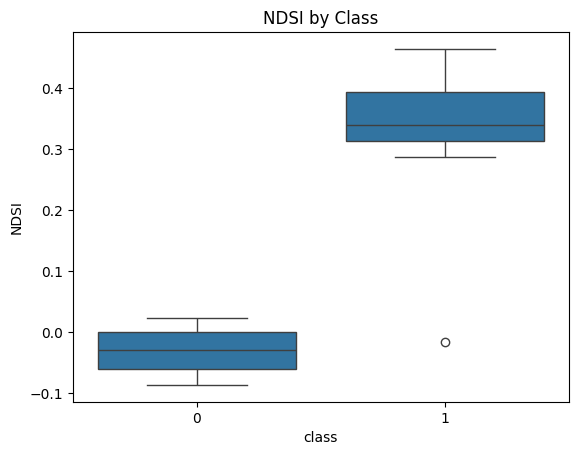

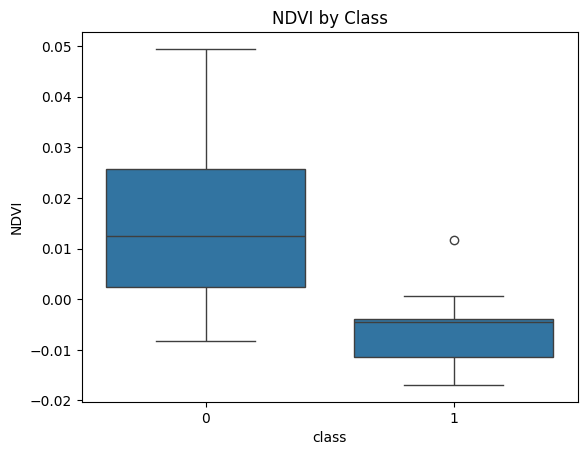

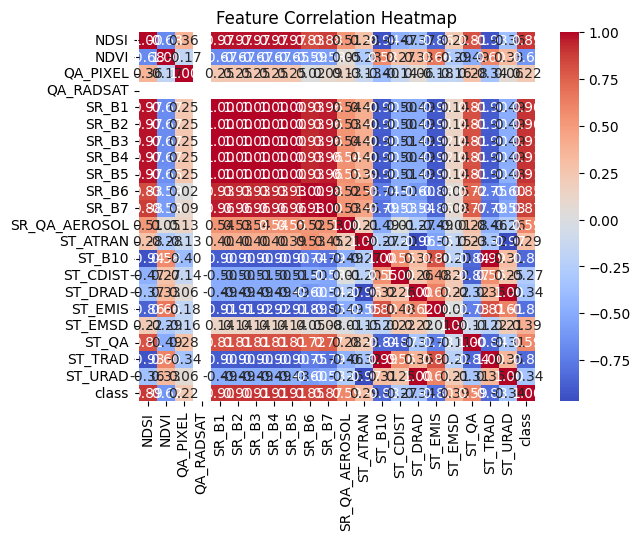

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of NDSI and NDVI by class
sns.boxplot(x='class', y='NDSI', data=df_clean)
plt.title('NDSI by Class')
plt.show()

sns.boxplot(x='class', y='NDVI', data=df_clean)
plt.title('NDVI by Class')
plt.show()

# Correlation heatmap
sns.heatmap(df_clean.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

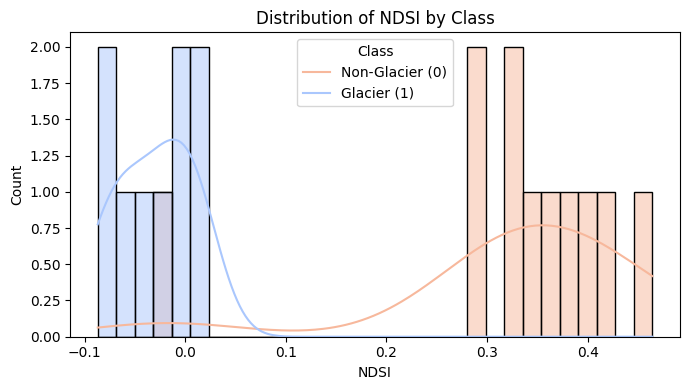

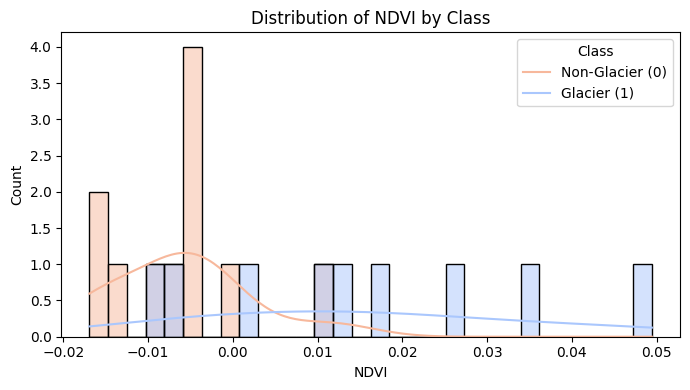

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for NDSI and NDVI
features = ['NDSI', 'NDVI']
for feature in features:
    plt.figure(figsize=(7, 4))
    sns.histplot(data=df_clean, x=feature, hue='class', kde=True, palette='coolwarm', bins=30)
    plt.title(f'Distribution of {feature} by Class')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Class', labels=['Non-Glacier (0)', 'Glacier (1)'])
    plt.tight_layout()
    plt.show()

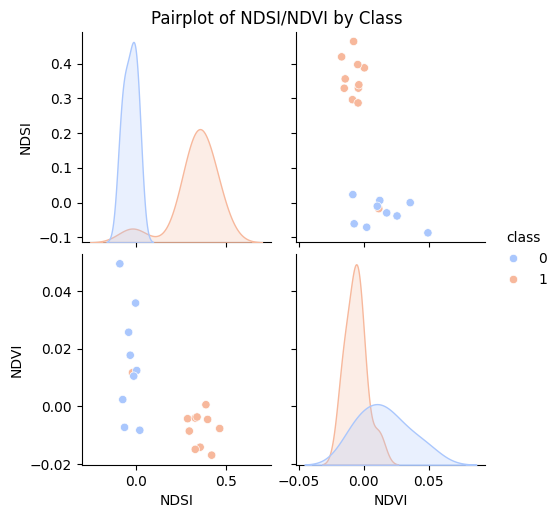

In [14]:
# Only select relevant columns
plot_features = ['NDSI', 'NDVI', 'class']
sns.pairplot(df_clean[plot_features], hue='class', palette='coolwarm', diag_kind='kde')
plt.suptitle("Pairplot of NDSI/NDVI by Class", y=1.02)
plt.show()


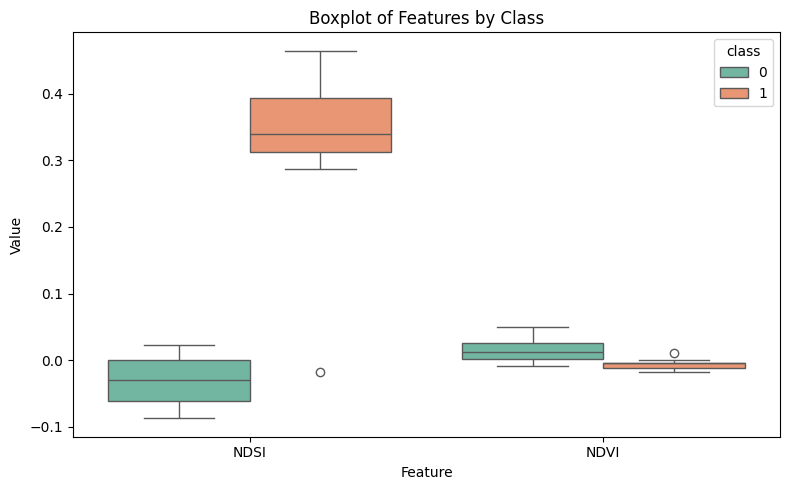

In [15]:
# Melt the DataFrame for boxplotting
melted = df_clean.melt(id_vars='class', value_vars=['NDSI', 'NDVI'])

plt.figure(figsize=(8, 5))
sns.boxplot(x='variable', y='value', hue='class', data=melted, palette='Set2')
plt.title("Boxplot of Features by Class")
plt.xlabel("Feature")
plt.ylabel("Value")
plt.tight_layout()
plt.show()


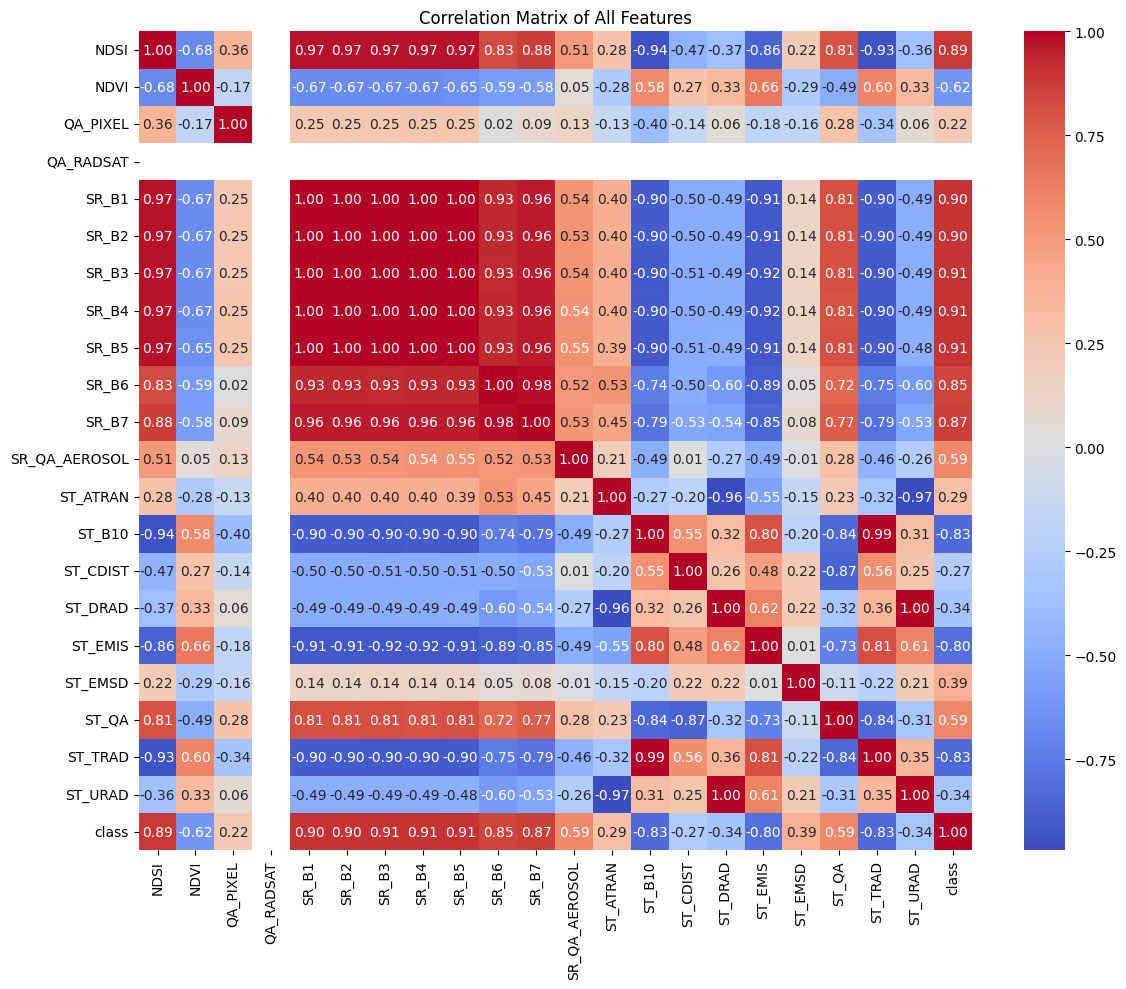

In [16]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of All Features")
plt.tight_layout()
plt.show()
